# Encoding Time Series Data as Image Fields #

In this experiment, we import the GunPoint data into the Aretas platform and export as Gramian Image fields.

The GunPoint dataset information can be found here: http://www.timeseriesclassification.com/description.php?Dataset=GunPoint

This model, using image fields, compares well to the best performing model on the site on previously unseen data (98%) 

Class 1 is "gun" and class 2 is "no gun (pointing)"

<img src="GunPoint.png" width="300px">

In [1]:
from fastai.vision.all import *

In [2]:
image_data_path = Path("GunPoint/train")

In [3]:
image_data_path.ls()

(#3) [Path('GunPoint/train/1'),Path('GunPoint/train/2'),Path('GunPoint/train/models')]

In [4]:
files = get_image_files(image_data_path)

In [5]:
len(files)

150

In [6]:
files[0]

Path('GunPoint/train/1/102.png')

In [7]:
files[0].parts[len(files[0].parts)-2]

'1'

In [8]:
def label_func(f):
    label = f.parts[len(f.parts)-2]
    return label


In [9]:
set_seed(8008, True)
dls = ImageDataLoaders.from_path_func(image_data_path, files, label_func,valid_pct=0.2, bs=32, item_tfms=Resize((200,200), ResizeMethod.Squish))

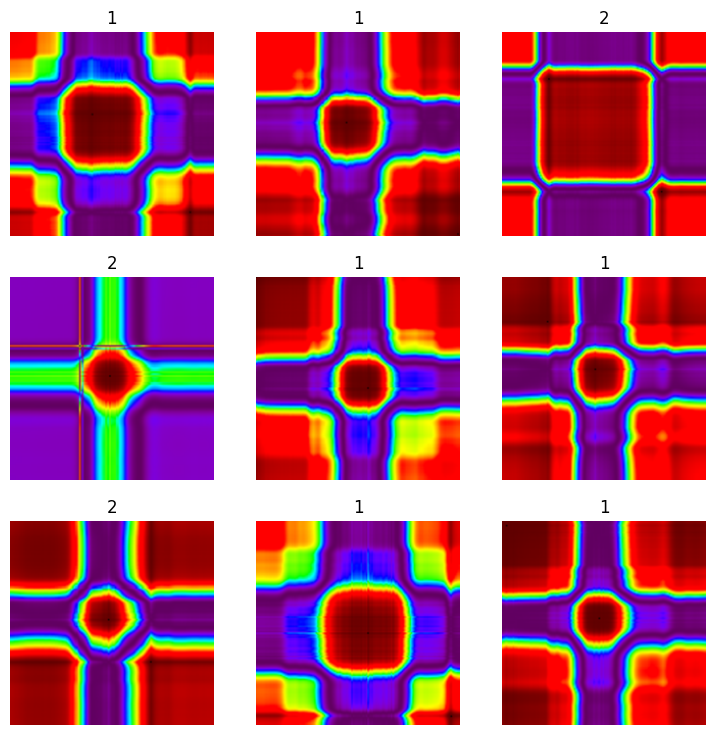

In [10]:
dls.show_batch()

SuggestedLRs(valley=0.00013182566908653826)

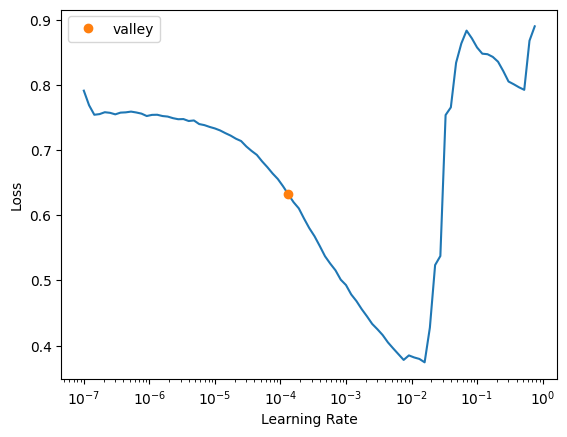

In [11]:
set_seed(8008, True)
learn = Learner(dls, xresnet50(n_out=2), metrics=accuracy)
learn.lr_find(num_it=100)

In [13]:
lr = 0.00013182566908653826
learn.fine_tune(13)

epoch,train_loss,valid_loss,accuracy,time
0,0.002972,1.658720,0.600000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.008836,0.381460,0.933333,00:00
1,0.007074,0.936407,0.800000,00:00
2,0.004824,0.025965,0.966667,00:00
3,0.003739,0.082250,1.000000,00:00
4,0.004784,0.496903,0.900000,00:00
5,0.007660,0.346641,0.900000,00:00
6,0.020121,0.576631,0.900000,00:00
7,0.017699,0.628841,0.866667,00:00
8,0.019866,0.143982,0.966667,00:00
9,0.017949,0.141080,0.966667,00:00


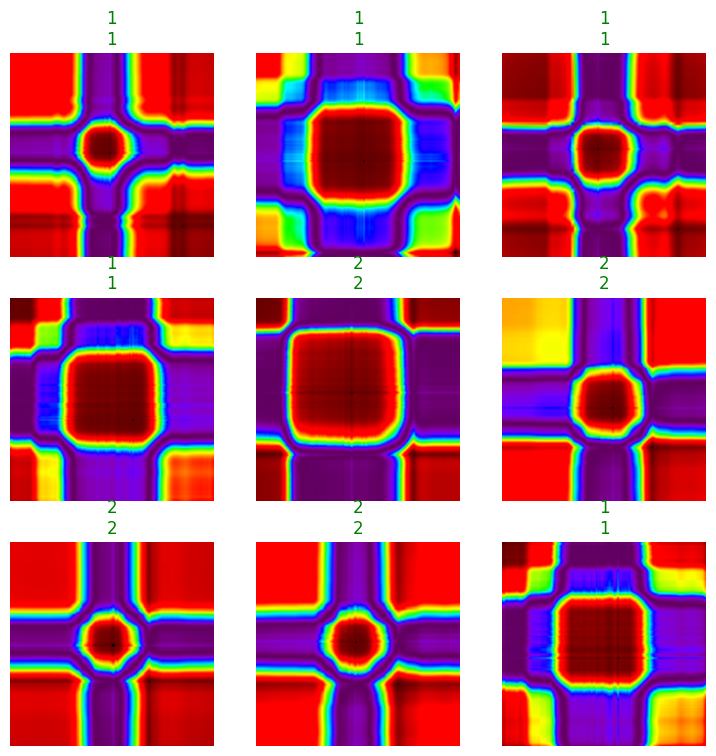

In [14]:
learn.show_results()

In [15]:
interp = Interpretation.from_learner(learn)

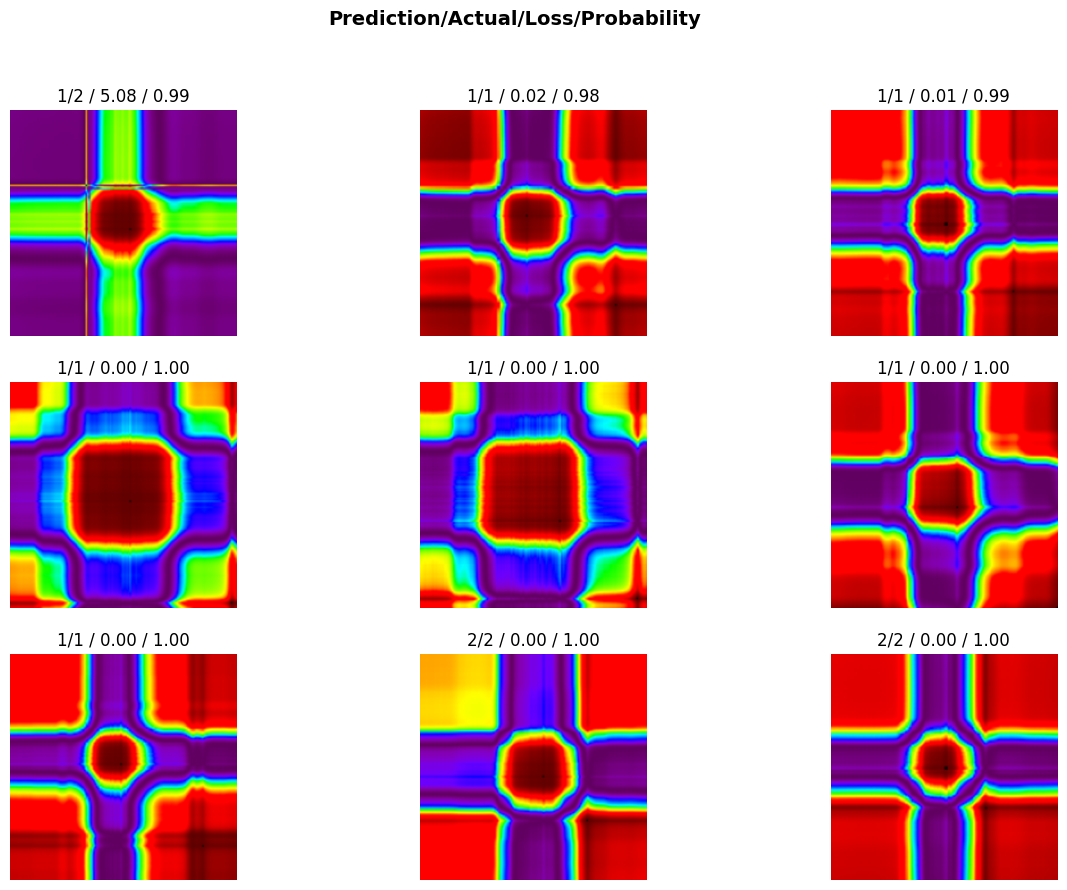

In [16]:
interp.plot_top_losses(9, figsize=(15,10))

In [17]:
test_set_path = Path("Y:/ai-time-series-classification-export-gaf/GunPoint/test")
test_set_images = get_image_files(test_set_path)
test_set_images

(#150) [Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/102.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/104.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/105.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/108.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/110.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/112.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/113.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/115.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/116.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/129.png')...]

In [18]:
%%capture
def get_conf_matrix(debug=False):
    
    accuracy = [[0.0,0.0],[0.0,0.0]]
    
    for i in test_set_images:
        
        result = learn.predict(i);
        actual = i.parts[len(i.parts)-2]
        prediction = result[0]
        
        if debug:
            
            print("---------------------------------")
            print("Actual:" + actual)
            print("Prediction:" + result[0])
            target_prob = result[2][0]
            print(float(target_prob))
            print(result)
            print("---------------------------------")
            print('\n')

        # true positive
        if(actual == '1' and prediction == '1'):
            accuracy[0][0] = accuracy[0][0] + 1.0

        # false negative
        if(actual == '1' and prediction != '1'):
            accuracy[1][0] = accuracy[1][0] + 1.0

        #false positive
        if(actual != '1' and prediction == '1'):
            accuracy[0][1] = accuracy[0][1] + 1.0

        #true negative
        if(actual != '1' and prediction != '1'):
            accuracy[1][1] = accuracy[1][1] + 1.0
            
    return accuracy

conf_matrix = get_conf_matrix()

Confusion matrix:

In [19]:
from IPython.display import display, HTML
display(HTML(pd.DataFrame(conf_matrix).to_html()))

,0,1
0,75.0,1.0
1,1.0,73.0


In [20]:
# accuracy
accuracy_t = Tensor(conf_matrix)
accuracy_val = accuracy_t.trace() / accuracy_t.sum()
print(accuracy_val)

tensor(0.9867)


In [21]:
# learn.export("GunpointGAF_best_98pct_accuracy.pkl")